# AWS ERA5 data

In [1]:
#notebook based on zflemings:https://nbviewer.jupyter.org/github/zflamig/dask-era5/blob/main/notebook/era5_fargate_dask.ipynb
import matplotlib.pyplot as plt
import xarray as xr
import fsspec
import dask
import s3fs
import numpy as np
import gcsfs
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

xr.set_options(display_style="html")  #display dataset nicely 

In [2]:
# see if zac's data more recent?
#https://nbviewer.jupyter.org/github/awslabs/amazon-asdi/blob/main/examples/dask/notebooks/era5_zarr.ipynb

%matplotlib inline
import boto3
import botocore
import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import s3fs
import fsspec
import dask
from dask.distributed import performance_report, Client, progress

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

In [3]:
#zac code
def fix_accum_var_dims(ds, var):
    # Some varibles like precip have extra time bounds varibles, we drop them here to allow merging with other variables
    
    # Select variable of interest (drops dims that are not linked to current variable)
    ds = ds[[var]]  

    if var in ['air_temperature_at_2_metres',
               'dew_point_temperature_at_2_metres',
               'air_pressure_at_mean_sea_level',
               'northward_wind_at_10_metres',
               'eastward_wind_at_10_metres']:
        
        ds = ds.rename({'time0':'valid_time_end_utc'})
        
    elif var in ['precipitation_amount_1hour_Accumulation',
                 'integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation']:
        
        ds = ds.rename({'time1':'valid_time_end_utc'})
        
    else:
        print("Warning, Haven't seen {var} varible yet! Time renaming might not work.".format(var=var))
        
    return ds

@dask.delayed
def s3open(path):
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False, 
                           config_kwargs = {'max_pool_connections': 20})
    return s3fs.S3Map(path, s3=fs)


def open_era5_range(start_year, end_year, variables):
    ''' Opens ERA5 monthly Zarr files in S3, given a start and end year (all months loaded) and a list of variables'''
    
    
    file_pattern = 'era5-pds/zarr/{year}/{month}/data/{var}.zarr/'
    
    years = list(np.arange(start_year, end_year+1, 1))
    months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    
    l = []
    for var in variables:
        print(var)
        
        # Get files
        files_mapper = [s3open(file_pattern.format(year=year, month=month, var=var)) for year in years for month in months]
        
        # Look up correct time dimension by variable name
        if var in ['precipitation_amount_1hour_Accumulation']:
            concat_dim='time1'
        else:
            concat_dim='time0'
            
        # Lazy load
        ds = xr.open_mfdataset(files_mapper, engine='zarr', 
                               concat_dim=concat_dim, combine='nested', 
                               coords='minimal', compat='override', parallel=True)
        
        # Fix dimension names
        ds = fix_accum_var_dims(ds, var)
        l.append(ds)
        
    ds_out = xr.merge(l)
    
    return ds_out



In [4]:
%%time
ds = open_era5_range(1979, 2020, ["eastward_wind_at_10_metres"])

eastward_wind_at_10_metres
CPU times: user 1min 56s, sys: 7.36 s, total: 2min 3s
Wall time: 6min 23s


In [5]:
ds

,Array,Chunk
Bytes,1.53 TB,33.48 MB
Shape,"(368184, 721, 1440)","(372, 150, 150)"
Count,101304 Tasks,50400 Chunks
Type,float32,numpy.ndarray


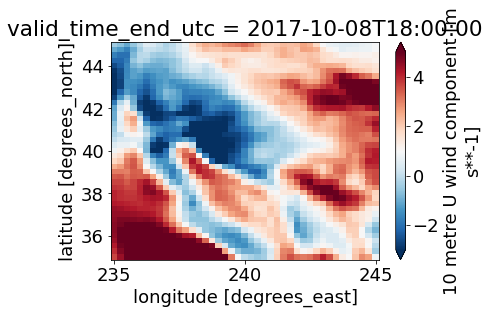

In [6]:
ds.eastward_wind_at_10_metres.sel(lon=slice(235,245),lat=slice(45,35),valid_time_end_utc='2017-10-08T18').plot(vmin=-3,vmax=5,cmap='RdBu_r')

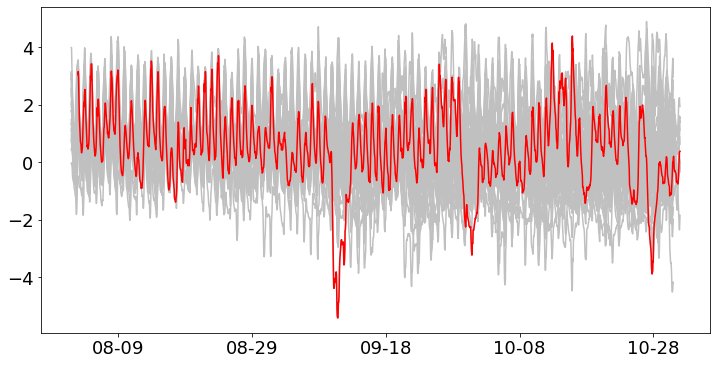

In [11]:
ts = ds.sel(lon=slice(236,239),lat=slice(46,41)).mean({'lat','lon'}).load()

fig, ax = plt.subplots(figsize=(12, 6))
for lyr in range(1979,2021):
    yr = ts.sel(valid_time_end_utc=slice(str(lyr)+'-08-01',str(lyr)+'-10-29'))
    xx=yr.valid_time_end_utc.dt.dayofyear+yr.valid_time_end_utc.dt.hour/24
    ax.plot(xx,yr.eastward_wind_at_10_metres,color='silver')
#color_order = ['green','grey','blue','red']
#for i,lyr in enumerate(np.arange(2017,2021)):
#    yr = ts.sel(valid_time_end_utc=slice(str(lyr)+'-08-01',str(lyr)+'-10-29'))
#    ax.plot(xx,yr.eastward_wind_at_10_metres,color=color_order[i])
color_order = ['red']
for i,lyr in enumerate(np.arange(2020,2021)):
    yr = ts.sel(valid_time_end_utc=slice(str(lyr)+'-08-01',str(lyr)+'-10-29'))
    ax.plot(xx,yr.eastward_wind_at_10_metres,color=color_order[i])
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)

In [9]:
ts_sr = ds.sel(lon=slice(237,240),lat=slice(42,40)).mean({'lat','lon'}).load()

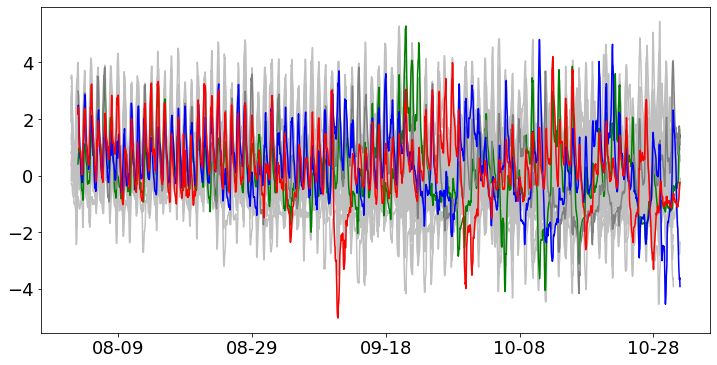

In [10]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
fig, ax = plt.subplots(figsize=(12, 6))
for lyr in range(1979,2021):
    yr = ts_sr.sel(valid_time_end_utc=slice(str(lyr)+'-08-01',str(lyr)+'-10-29'))
    xx=yr.valid_time_end_utc.dt.dayofyear+yr.valid_time_end_utc.dt.hour/24
    ax.plot(xx,yr.eastward_wind_at_10_metres,color='silver')
color_order = ['green','grey','blue','red']
for i,lyr in enumerate(np.arange(2017,2021)):
    yr = ts_sr.sel(valid_time_end_utc=slice(str(lyr)+'-08-01',str(lyr)+'-10-29'))
    ax.plot(xx,yr.eastward_wind_at_10_metres,color=color_order[i])
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)

In [ ]:
ts.to_netcdf('../../data/era5ts.nc')
ts_sr.to_netcdf('../../data/era5ts_sr.nc')

# read in

In [ ]:
with xr.open_dataset('../../data/era5ts_sr.nc') as ts_sr:
    print(ts_sr)

In [ ]:
#only keep sept/oct (months high fire danger) data
fall = ts_sr.where((ts_sr.valid_time_end_utc.dt.month>=9) & (ts_sr.valid_time_end_utc.dt.month<=10))
fall.eastward_wind_at_10_metres.plot()

In [ ]:
# are these individual events (like in 1999 where there was just one 6-hour map with high winds or different events?)
# try calculating max wind for each day & redoing to see numbers of days?
falldy = fall.resample(valid_time_end_utc='1D').min()  #looking for most negative large winds so min rather than max
falldy

In [ ]:
#plot histogram how often strong winds occur
fig, ax = plt.subplots(figsize=(12, 6))
yr = falldy.valid_time_end_utc.dt.year
yr = yr.where(falldy.eastward_wind_at_10_metres<-2.9)
#h,bins=np.histogram(yr,bins=np.arange(1984,2021))
ax.hist(yr,bins=np.arange(1984,2022),label='U<-2.9 m/s')
ax.set_xlabel('Year'),ax.set_ylabel('Days with Strong Eastward Winds')
yr = yr.where(falldy.eastward_wind_at_10_metres<-4.1)
#h,bins=np.histogram(yr,bins=np.arange(1984,2021))
ax.hist(yr,bins=np.arange(1984,2022),label='U<-4.1 m/s')
ax.set_xlabel('Year'),ax.set_ylabel('Days with Strong Eastward Winds')
ax.grid()
ax.legend()

In the last 36 years, medium wind events occured intermittently, with a 5 year stretch 1990-1995 where 1-2 dy/yr an event occured. In the last 4 years, all have had 2-5 days of these events.  All of the high wind events occur since 2005, with 4/6 in the last 4 years.

# what are the dates of the medium and high events?

In [ ]:
yr = falldy.valid_time_end_utc.dt.year
yr = yr.where(falldy.eastward_wind_at_10_metres<-2.9)
high_dates = falldy.where(~np.isnan(yr),drop=True)
high_dates.valid_time_end_utc.data

In [ ]:
yr = falldy.valid_time_end_utc.dt.year
yr = yr.where(falldy.eastward_wind_at_10_metres<-4.1)
high_dates = falldy.where(~np.isnan(yr),drop=True)
high_dates.valid_time_end_utc.data

In [ ]:
tem = falldy.sel(valid_time_end_utc=slice('2019-10-20','2019-10-30'))
tem.eastward_wind_at_10_metres

# so what is going on with the storms?

In [11]:
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
#ds  = cat["era5_hourly_reanalysis_single_levels_sa"].to_dask()
#ds_wnd = ds.u10
list(cat)

['sea_surface_height',
 'cesm_mom6_example',
 'ECCOv4r3',
 'SOSE',
 'GODAS',
 'ECCO_layers',
 'altimetry',
 'LLC4320',
 'GFDL_CM2_6',
 'CESM_POP',
 'channel',
 'MEOM_NEMO']

In [6]:
ds = cat['SOSE'].to_dask()
ds

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    PHrefC    (Z) float32 dask.array<chunksize=(42,), meta=np.ndarray>
    PHrefF    (Zp1) float32 dask.array<chunksize=(43,), meta=np.ndarray>
  * XC        (XC) float32 0.08333 0.25 0.4167 0.5833 ... 359.6 359.8 359.9
  * XG        (XG) float32 5.551e-17 0.1667 0.3333 0.5 ... 359.5 359.7 359.8
  * YC        (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -25.04 -24.87 -24.71
  * YG        (YG) float32 -77.96 -77.79 -77.62 -77.46 ... -25.12 -24.96 -24.79
  * Z         (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * Zl        (Zl) float32 0.0 -10.0 -21.0 ... -4.95e+03 -5.2e+03 -5.45e+03
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 ... -5.2e+03 -5.45e+03 -5.7e+03
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 ... -5.2e+03 -5.45e+03 -5.7e+03
    drC       (Zp1) float32 dask.array<chunksize=(43,), meta=np.ndarray>
    drF       (Z) float32 dask.array<chunksize=(42,), meta=np.ndarray>
    dxC       (YC, XG) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    dxG       (YG, XC) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    dyC       (YG, XC) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    dyG       (YC, XG) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    hFacC     (Z, YC, XC) float32 dask.array<chunksize=(42, 320, 2160), meta=np.ndarray>
    hFacS     (Z, YG, XC) float32 dask.array<chunksize=(42, 320, 2160), meta=np.ndarray>
    hFacW     (Z, YC, XG) float32 dask.array<chunksize=(42, 320, 2160), meta=np.ndarray>
    iter      (time) int64 dask.array<chunksize=(438,), meta=np.ndarray>
    rA        (YC, XC) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    rAs       (YG, XC) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    rAw       (YC, XG) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    rAz       (YG, XG) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ADVr_TH   (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ADVx_SLT  (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ADVx_TH   (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ADVy_SLT  (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ADVy_TH   (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    DFrE_SLT  (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    DFrE_TH   (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    DFrI_SLT  (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    DFrI_TH   (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    DFxE_SLT  (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    DFxE_TH   (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    DFyE_SLT  (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    DFyE_TH   (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    DRHODR    (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ETAN      (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    EXFswnet  (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    KPPg_SLT  (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    KPPg_TH   (time, Zl, YC, XC) float3

In [16]:
%%time
# test for bill

ds = open_era5_range(1979, 2020, ["northward_wind_at_10_metres"])
ts2 = ds.sel(lon=slice(236,239),lat=slice(39,37)).mean({'lat','lon'}).load()

northward_wind_at_10_metres
CPU times: user 3min 42s, sys: 18.3 s, total: 4min 1s
Wall time: 8min 17s


In [31]:
ts2

<xarray.Dataset>
Dimensions:                      (valid_time_end_utc: 368184)
Coordinates:
  * valid_time_end_utc           (valid_time_end_utc) datetime64[ns] 1979-01-...
Data variables:
    northward_wind_at_10_metres  (valid_time_end_utc) float32 -2.193 ... -5.042

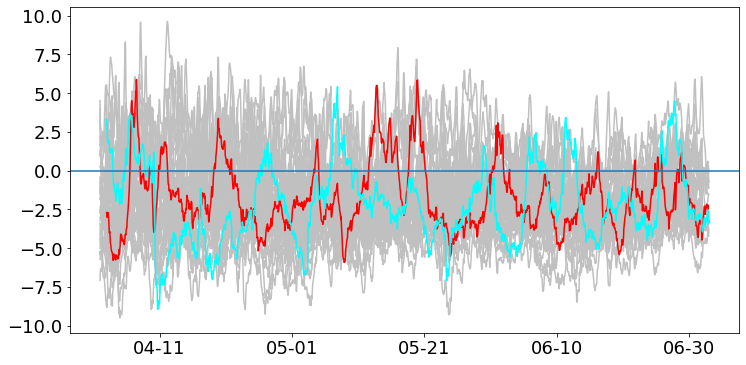

In [32]:

fig, ax = plt.subplots(figsize=(12, 6))
for lyr in range(1979,2021):
    yr = ts2.sel(valid_time_end_utc=slice(str(lyr)+'-04-01',str(lyr)+'-06-30'))
    xx=yr.valid_time_end_utc.dt.dayofyear+yr.valid_time_end_utc.dt.hour/24
    ax.plot(xx,yr.northward_wind_at_10_metres,color='silver')
#color_order = ['green','grey','blue','red']
#for i,lyr in enumerate(np.arange(2017,2021)):
#    yr = ts.sel(valid_time_end_utc=slice(str(lyr)+'-08-01',str(lyr)+'-10-29'))
#    ax.plot(xx,yr.eastward_wind_at_10_metres,color=color_order[i])
color_order = ['red']
for i,lyr in enumerate(np.arange(2020,2021)):
    yr = ts2.sel(valid_time_end_utc=slice(str(lyr)+'-04-01',str(lyr)+'-06-30'))
    ax.plot(xx,yr.northward_wind_at_10_metres,color=color_order[i])
color_order = ['cyan']
for i,lyr in enumerate(np.arange(2013,2014)):
    yr = ts2.sel(valid_time_end_utc=slice(str(lyr)+'-04-01',str(lyr)+'-06-30'))
    ax.plot(xx,yr.northward_wind_at_10_metres,color=color_order[i])
ax.axhline(y=0)
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)

In [14]:
yr

<xarray.Dataset>
Dimensions:                     (valid_time_end_utc: 1464)
Coordinates:
  * valid_time_end_utc          (valid_time_end_utc) datetime64[ns] 1979-04-0...
Data variables:
    eastward_wind_at_10_metres  (valid_time_end_utc) float32 3.551 ... 1.595